# Load Kinecal Data ELEC872 Project
### Cameron Bishop | November 16th 2022

In [1]:
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import time

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
import random

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder #Standardization and conversion of categorical labels to binary representation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score

import LoadKinecalFunctions
from LoadKinecalFunctions import *
importlib.reload(LoadKinecalFunctions)
from const import User, Exercise
import models
from models import *
importlib.reload(models)



<module 'models' from 'c:\\Users\\camb7\\Code Repositories\\KINECAL Balance Assessment\\KINECAL-Balance-Assessment\\models.py'>

In [2]:
user = User.CD
excerciseList = [Exercise.QSECFS, Exercise.QSEOFS, Exercise.STS, Exercise.TS]

QSClosedDf = readKinecalFiles(excerciseList[0], user) 
QSOpenDf = readKinecalFiles(excerciseList[1], user) 
SemiTandemDf = readKinecalFiles(excerciseList[2], user) 
TandemDf = readKinecalFiles(excerciseList[3], user) 


### Seperate X and Y Dataframes

In [3]:
yDf = QSClosedDf.iloc[:, 0:9]
yDf = yDf.drop(columns='movement')

QSClosedXDf = QSClosedDf.iloc[:, 9:-1]
QSOpenXDf = QSOpenDf.iloc[:, 9:-1]
SemiTandemXDf = SemiTandemDf.iloc[:, 9:-1]
TandemXDf = TandemDf.iloc[:, 9:-1]

print(yDf)

   part_id group sex  height  weight   BMI recorded_in_the_lab  \
0       10    HA   m    1.85    77.0  22.5                   1   
1      100    NF   f    1.55    82.5  34.3                   1   
2       11    HA   f    1.57    51.5  20.9                   1   
3       12    HA   m    1.64    68.5  25.5                   1   
4       13    HA   m    1.78    85.0  26.8                   1   
..     ...   ...  ..     ...     ...   ...                 ...   
85      84   FHm   f    1.56    60.0  24.7                   0   
86      87   FHs   f    1.60    77.1  30.1                   0   
87       9    HA   m    1.69    75.0  26.3                   1   
88      92    NF   m    1.83    97.0  29.0                   0   
89      96   FHs   m    1.78    81.2  25.6                   0   

   clinically_at_risk  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
..                ...  
85                  0  
86             

### Replace Missing Data With Mean of That Class

In [4]:
QSClosedXDf = replaceMissingValues(QSClosedXDf, yDf)
QSOpenXDf = replaceMissingValues(QSOpenXDf, yDf)
SemiTandemXDf = replaceMissingValues(SemiTandemXDf, yDf)
TandemXDf = replaceMissingValues(TandemXDf, yDf)


[ 2 14 15]
[ 2 17 29 34 71]
[ 2 14 17 31 33 60 66]
[13 14 17 29 31 33 36 37 55 60 66 74 77]


### Perform Sample Normalization

In [5]:
#print(np.asarray(QS_Closed_x_df.iloc[0,:].values))
QSClosedXNormDf = datasetNormalization(QSClosedXDf)
QSOpenXNormDf = datasetNormalization(QSOpenXDf)
SemiTandemXNormDf = datasetNormalization(SemiTandemXDf)
TandemXNormDf = datasetNormalization(TandemXDf)

### Combine Excercises Into One Dataset

In [6]:
print(QSClosedXNormDf.shape, QSOpenXNormDf.shape, SemiTandemXNormDf.shape, TandemXNormDf.shape)
combinedXNormDf = pd.concat([QSClosedXNormDf, QSOpenXNormDf, SemiTandemXNormDf, TandemXDf], axis=1)
print(combinedXNormDf.shape)

(90, 16) (90, 16) (90, 16) (90, 16)
(90, 64)


### Seperate Into Training and Testing Sets

In [40]:

xTrain, xTest, yTrain, yTest = train_test_split(combinedXNormDf, yDf, test_size=0.2, random_state=42)

le = LabelEncoder()

yTest_orig = yTest
yTrain_orig = yTrain

xTest_orig = xTest
xTrain_orig = xTrain

yTest = le.fit_transform(yTest.group.values)
yTrain = le.fit_transform(yTrain.group.values)

X = np.asarray(combinedXNormDf)
y = np.asarray(le.fit_transform(yDf.group.values))

xTest = np.asarray(xTest)
xTrain = np.asarray(xTrain) 



In [41]:
from sklearn.metrics import f1_score
def hyperopt_multiclass(param_space, xTrain, yTrain, xTest, yTest, num_rounds=100):
    start = time.time()
    
    def objective(param_space):
        clf = xgb.XGBClassifier(**param_space)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        score = cross_val_score(clf, xTrain, yTrain, cv=skf, scoring='f1_weighted').mean()
        return {'loss': -score, 'status': STATUS_OK}
    
    trials = Trials()
    best_param = fmin(fn=objective, 
                    space=param_space, 
                    algo=tpe.suggest, 
                    max_evals=num_rounds,
                    trials=trials)
    loss = [x['result']['loss'] for x in trials.trials]
    
    #ensure best_param dictionary has right data types
    best_param['max_depth'] = int(best_param['max_depth'])
    best_param['tree_method'] = ['exact', 'gpu_hist'][best_param['tree_method']]
    best_param['objective'] = ['multi:softmax', 'multi:softprob'][best_param['objective']]
    
    best_clf = xgb.XGBClassifier(**best_param)
    best_clf.fit(xTrain, yTrain)
    
    print('==============RESULTS==============')
    print('Best parameters: ', best_param)
    print('Best loss: ', -np.min(loss))
    print('Time taken: ', time.time() - start)
    print('Test accuracy: ', f1_score(yTest, best_clf.predict(xTest), average='weighted'))
    print('Parameter combinations evaluated: ', len(trials.trials))
    return best_clf, best_param, trials


### Train XGBoost Model

In [45]:
param_space = {
    'tree_method': hp.choice('tree_method', ['exact', 'gpu_hist']),
    'objective': hp.choice('objective', ['multi:softmax']),
    'max_depth': scope.int(hp.quniform("max_depth", 3, 10, 2)),
    'gamma': hp.uniform('gamma', 0.5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'min_child_weight' : scope.int(hp.quniform('min_child_weight', 1, 10, 1)),
    'num_class': 4
}

best_clf, best_param, trials = hyperopt_multiclass(param_space, xTrain, yTrain, xTest, yTest, num_rounds=75)

100%|██████████| 75/75 [02:10<00:00,  1.74s/trial, best loss: -0.5926735486735486]
==============RESULTS==============
Best parameters:  {'gamma': 0.9625253704066923, 'max_depth': 10, 'min_child_weight': 1.0, 'objective': 'multi:softmax', 'subsample': 0.5707646253609256, 'tree_method': 'gpu_hist'}
Best loss:  0.5926735486735486
Time taken:  131.2174482345581
Test accuracy:  0.4369087702421036
Parameter combinations evaluated:  75


### Create Optimal XGBoost Model

In [46]:
y_pred = best_clf.predict(xTest)

y_pred_label = le.inverse_transform(y_pred)
y_test_label = le.inverse_transform(yTest)

### Create Confusion Matrix and Classification Report

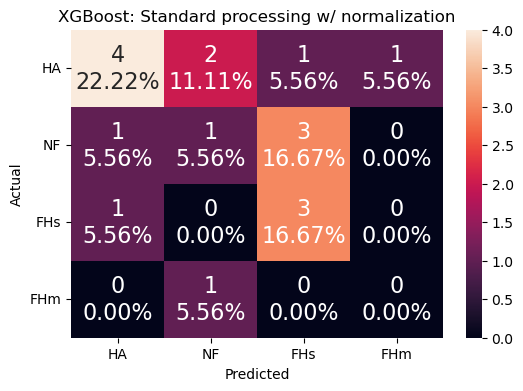

              precision    recall  f1-score   support

         FHm       0.00      0.00      0.00         1
         FHs       0.43      0.75      0.55         4
          HA       0.67      0.50      0.57         8
          NF       0.25      0.20      0.22         5

    accuracy                           0.44        18
   macro avg       0.34      0.36      0.33        18
weighted avg       0.46      0.44      0.44        18



In [47]:
classes = ['HA','NF','FHs','FHm']
cm_python = confusion_matrix(y_true=y_test_label, y_pred=y_pred_label, labels=classes)

plt.subplots(figsize=(6,4))

group_counts = ['{0:0.0f}'.format(value) for value in
                cm_python.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_python.flatten()/np.sum(cm_python)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)
df_cm_python = pd.DataFrame(cm_python)

sns.heatmap(df_cm_python, annot=labels, fmt='',annot_kws={"size": 16}, xticklabels=classes, yticklabels=classes) # font size
plt.title('XGBoost: Standard processing w/ normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual') 
plt.yticks(rotation=0)
plt.show()

print(classification_report(y_true=y_test_label, y_pred=y_pred_label))

### Remap Labels to Be Binary Single Fallers Included as Fallers

In [ ]:
yTrainBinary = binaryLabelRemapping(yTrain, True)
yTestBinary = binaryLabelRemapping(yTest, True)

### Tune XGBoost

In [ ]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-4, 1e-5, 'scale', 'auto'], 'C': [100, 250, 500, 750, 1000]},
                        {'kernel': ['sigmoid'], 'gamma': [1e-4, 1e-5, 'scale', 'auto'], 'C': [100, 250, 500, 750, 1000]}]
modelDir = './models/'
modelName = 'tunedSVM5Fold_binarylabelsTrue'
svmModel = tune_svm(xTrain,yTrainBinary.label_binary.values, tuned_parameters, 5)

### Train XGBoost with Optimal Parameters For Binary Labels Single Fallers are Fallers

In [ ]:
clf = svm.SVC(kernel = 'rbf' , C = 250, gamma='scale', probability=True)
clf.fit(xTrain, yTrainBinary.label_binary.values)

y_pred = clf.predict(xTest)

### Create Confusion Matrix For Binary Labels

In [ ]:
classes = ['Faller', 'Non-Faller']
cm_python = confusion_matrix(y_true=yTestBinary.label_binary.values, y_pred=y_pred, labels=classes)

plt.subplots(figsize=(6,4))

group_counts = ['{0:0.0f}'.format(value) for value in
                cm_python.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_python.flatten()/np.sum(cm_python)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
df_cm_python = pd.DataFrame(cm_python)

sns.heatmap(df_cm_python, annot=labels, fmt='',annot_kws={"size": 16}, xticklabels=classes, yticklabels=classes) # font size
plt.title('Test Model: Standard processing w/normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.show()


print(classification_report(y_true=yTestBinary.label_binary.values, y_pred=y_pred))


### Obtain Missclassifications

In [ ]:
missclassifications = yTestBinary.loc[yTestBinary.label_binary!=y_pred]
print(missclassifications)

### Remap Labels to Be Binary Single Fallers Included as Non-Fallers

In [ ]:
yTrainBinary = binaryLabelRemapping(yTrain, False)
yTestBinary = binaryLabelRemapping(yTest, False)

### Tune XGBoost

In [ ]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-4, 1e-5, 'scale', 'auto'], 'C': [100, 250, 500, 750, 1000]},
                        {'kernel': ['sigmoid'], 'gamma': [1e-4, 1e-5, 'scale', 'auto'], 'C': [100, 250, 500, 750, 1000]}]
modelDir = './models/'
modelName = 'tunedSVM5Fold_binarylabelsFalse'
svmModel = tune_svm(xTrain,yTrainBinary.label_binary.values, tuned_parameters, 5)

### Train XGBoost with Optimal Parameters Single Fallers Considered Non-Fallers

In [ ]:
clf = svm.SVC(kernel = 'sigmoid' , C = 750, gamma=0.0001, probability=True)
clf.fit(xTrain, yTrainBinary.label_binary.values)

y_pred = clf.predict(xTest)

### Create Confusion Matrix For Binary Labels FHs -> Non-Fallers

In [ ]:
classes = ['Faller', 'Non-Faller']
cm_python = confusion_matrix(y_true=yTestBinary.label_binary.values, y_pred=y_pred, labels=classes)

plt.subplots(figsize=(6,4))

group_counts = ['{0:0.0f}'.format(value) for value in
                cm_python.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm_python.flatten()/np.sum(cm_python)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
df_cm_python = pd.DataFrame(cm_python)

sns.heatmap(df_cm_python, annot=labels, fmt='',annot_kws={"size": 16}, xticklabels=classes, yticklabels=classes) # font size
plt.title('Test Model: Standard processing w/normalization')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.yticks(rotation=0)
plt.show()


print(classification_report(y_true=yTestBinary.label_binary.values, y_pred=y_pred))


### Obtain Missclassifications

In [ ]:
missclassifications = yTestBinary.loc[yTestBinary.label_binary!=y_pred]
print(missclassifications)